In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, concat
import glob

In [2]:
locn = "C:\\Users\\rangy\\Downloads\\hyddata\\features\\*.txt"
# find all the txt files in the path 
files = glob.glob(locn)
# use a dict to save all the variables 
features = {}

In [3]:
for name in files:
    try:
        with open(name) as f:
            # read in the data 
            temp_df = pd.read_csv(name,delim_whitespace=True,header=None)
            # make the row names cycle as a variable
            temp_df.index.name = 'cycle'
            temp_df.reset_index(inplace=True)
            # transpose the data 
            temp_df_transposed= temp_df.T
            # make the seconds a variable, call it "time”
            temp_df_transposed.index.name = 'time'
            temp_df_transposed.reset_index(inplace=True)
            # add a prefix cycle in the column names to help with pivoting data (from wide to long)
            string = ' cycle'.join(str(e) for e in list(temp_df_transposed.columns))
            temp_df_transposed.columns = string.split(" ")
            # From wide to long to help with joining all the variables 
            temp_df_long = pd.wide_to_long(temp_df_transposed.iloc[1:,:],stubnames='cycle', i=['time'], j='c')
            temp_df_long.reset_index(inplace=True)
            # save each data variable in the long format into separate data frames in the dictionary called "features"
            # but exclude path and txt in the names
            features[name[9:-4]] = temp_df_long
                        
           
    
    # prevent a possible error
    except IOError as exc:
        if exc.errno != errno.EISDIR:
            raise

In [5]:
label = pd.read_csv("C:\\Users\\rangy\\Downloads\\hyddata\\profile.txt",delim_whitespace=True,header=None)
label.columns = ['cooler_condition', 'valve_condition', 'pump_leak', 'hydraulic_accumulator', 'stable_flag']

In [6]:
for key in list(features.keys()):
    features[key].columns=['seconds','cycle',key]

In [14]:
dfs= [features['rangy\\Downloads\\hyddata\\features\\CE'],
      features['rangy\\Downloads\\hyddata\\features\\CP'],
      features['rangy\\Downloads\\hyddata\\features\\EPS1'],
      features['rangy\\Downloads\\hyddata\\features\\FS1'],
      features['rangy\\Downloads\\hyddata\\features\\FS2'],
      features['rangy\\Downloads\\hyddata\\features\\PS1'],
      features['rangy\\Downloads\\hyddata\\features\\PS2'],
      features['rangy\\Downloads\\hyddata\\features\\PS3'],
      features['rangy\\Downloads\\hyddata\\features\\PS4'],
      features['rangy\\Downloads\\hyddata\\features\\PS5'],
      features['rangy\\Downloads\\hyddata\\features\\PS6'],
      features['rangy\\Downloads\\hyddata\\features\\SE'],
      features['rangy\\Downloads\\hyddata\\features\\TS1'],
      features['rangy\\Downloads\\hyddata\\features\\TS2'],
      features['rangy\\Downloads\\hyddata\\features\\TS3'],
      features['rangy\\Downloads\\hyddata\\features\\TS4'],
      features['rangy\\Downloads\\hyddata\\features\\VS1']]

In [15]:
from functools import reduce
features_join = reduce(lambda left,right: pd.merge(left,right,on=['seconds','cycle']), dfs)

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [ ]:
univar = series_to_supervised(label[['hydraulic_accumulator']],n_in=2,n_out=1)
univar = univar.values

train,test = univar[:1201,:], univar[1202:,:]

xtrain,ytrain = train[:,0:2],train[:,-1]
xtest,ytest = test[:,0:2],test[:,-1]

In [211]:
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [212]:
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)

(1201, 1, 2) (1001, 1, 2) (1201,) (1001,)


In [58]:
%pip install keras
%pip install tensorflow
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [215]:
model = Sequential()
model.add(LSTM(60, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(xtrain, ytrain, epochs=50, batch_size=20, validation_data=(xtest, ytest), verbose=0, shuffle=False)

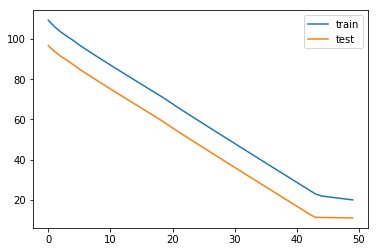

In [216]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [217]:
yhat = model.predict(xtest)
from sklearn.metrics import mean_absolute_error
mean_absolute_error(yhat,ytest)

10.948436062533657

In [250]:
bivar = series_to_supervised(label[['cooler_condition', 'valve_condition', 'pump_leak','stable_flag']],n_in=2,n_out=1)
bivar = bivar.values

train_second,test_second = bivar[:1201,:], bivar[1202:,:]

xtrain_second,ytrain_second = train_second[:,0:3],train_second[:,-1]
xtest_second,ytest_second = test_second[:,0:3],test_second[:,-1]

xtrain_second = xtrain_second.reshape((xtrain_second.shape[0], 1, xtrain_second.shape[1]))
xtest_second = xtest_second.reshape((xtest_second.shape[0], 1, xtest_second.shape[1]))


In [254]:
bimodel = Sequential()
bimodel.add(LSTM(60, input_shape=(xtrain_second.shape[1], xtrain_second.shape[2])))
bimodel.add(Dense(5))
bimodel.add(Dense(1))
bimodel.compile(loss='mae', optimizer='adam')
# fit network
bihistory = bimodel.fit(xtrain_second, ytrain_second, epochs=100, batch_size=20, validation_data=(xtest_second, ytest_second), verbose=0, shuffle=False)

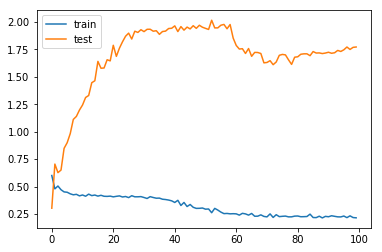

In [255]:
pyplot.plot(bihistory.history['loss'], label='train')
pyplot.plot(bihistory.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [256]:
trivar = series_to_supervised(label[['cooler_condition', 'valve_condition', 'pump_leak']],n_in=2,n_out=1)
trivar = trivar.values

train_third,test_third = trivar[:1201,:], trivar[1202:,:]

xtrain_third,ytrain_third = train_third[:,0:2],train_third[:,-1]
xtest_third,ytest_third = test_third[:,0:2],test_third[:,-1]

xtrain_third = xtrain_third.reshape((xtrain_third.shape[0], 1, xtrain_third.shape[1]))
xtest_third = xtest_third.reshape((xtest_third.shape[0], 1, xtest_third.shape[1]))

trimodel = Sequential()
trimodel.add(LSTM(60, input_shape=(xtrain_third.shape[1], xtrain_third.shape[2])))
trimodel.add(Dense(1))
trimodel.compile(loss='mae', optimizer='adam')
# fit network
trihistory = trimodel.fit(xtrain_third, ytrain_third, epochs=50, batch_size=20, validation_data=(xtest_third, ytest_third), verbose=0, shuffle=False)

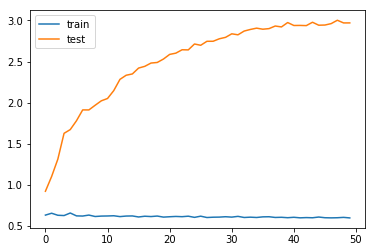

In [257]:
pyplot.plot(trihistory.history['loss'], label='train')
pyplot.plot(trihistory.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [258]:
valvevar = series_to_supervised(label[['valve_condition']],n_in=2,n_out=1)
valvevar = valvevar.values

train_valve,test_valve = valvevar[:1201,:], valvevar[1202:,:]

xtrain_valve,ytrain_valve = train_valve[:,0:2],train_valve[:,-1]
xtest_valve,ytest_valve = test_valve[:,0:2],test_valve[:,-1]

xtrain_valve = xtrain_valve.reshape((xtrain_valve.shape[0], 1, xtrain_valve.shape[1]))
xtest_valve = xtest_valve.reshape((xtest_valve.shape[0], 1, xtest_valve.shape[1]))

In [259]:
valve_model = Sequential()
valve_model.add(LSTM(60, input_shape=(xtrain_valve.shape[1], xtrain_valve.shape[2])))
valve_model.add(Dense(1))
valve_model.compile(loss='mae', optimizer='adam')
# fit network
valve_history = valve_model.fit(xtrain_valve, ytrain_valve, epochs=50, batch_size=20, validation_data=(xtest_valve, ytest_valve), verbose=0, shuffle=False)

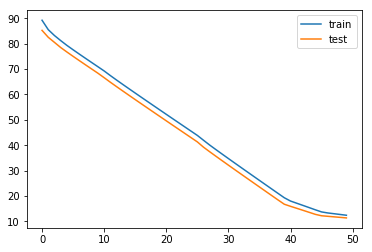

In [260]:
pyplot.plot(valve_history.history['loss'], label='train')
pyplot.plot(valve_history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [27]:
features_join

,seconds,cycle,rangy\Downloads\hyddata\features\CE,rangy\Downloads\hyddata\features\CP,rangy\Downloads\hyddata\features\EPS1,rangy\Downloads\hyddata\features\FS1,rangy\Downloads\hyddata\features\FS2,rangy\Downloads\hyddata\features\PS1,rangy\Downloads\hyddata\features\PS2,rangy\Downloads\hyddata\features\PS3,rangy\Downloads\hyddata\features\PS4,rangy\Downloads\hyddata\features\PS5,rangy\Downloads\hyddata\features\PS6,rangy\Downloads\hyddata\features\SE,rangy\Downloads\hyddata\features\TS1,rangy\Downloads\hyddata\features\TS2,rangy\Downloads\hyddata\features\TS3,rangy\Downloads\hyddata\features\TS4,rangy\Downloads\hyddata\features\VS1
0,0,0,47.202,2.184,2411.6,8.990,10.179,151.47,125.500,2.305,0.000,9.936,9.818,68.039,35.570,40.961,38.320,30.363,0.604
1,1,0,47.273,2.184,2411.6,0.770,10.174,151.45,125.390,2.305,0.000,9.947,9.823,0.000,35.492,40.949,38.332,30.375,0.605
2,2,0,47.250,2.184,2411.6,0.641,10.151,151.52,125.400,2.336,0.000,9.964,9.844,0.000,35.469,40.965,38.320,30.367,0.611
3,3,0,47.332,2.185,2411.6,0.006,10.149,151.27,125.030,2.578,0.000,9.989,9.861,0.000,35.422,40.922,38.324,30.367,0.603
4,4,0,47.213,2.178,2411.6,0.000,10.172,150.80,124.050,2.977,0.000,9.996,9.877,0.000,35.414,40.879,38.332,30.379,0.608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132295,55,2204,46.355,2.134,2652.0,0.001,10.179,186.38,0.562,0.000,10.235,9.999,9.873,68.167,35.441,40.910,38.195,30.395,0.516
132296,56,2204,46.432,2.146,2667.0,0.000,10.183,187.20,0.555,0.000,10.198,9.976,9.861,68.167,35.437,40.895,38.184,30.391,0.528
132297,57,2204,46.384,2.144,2690.8,0.000,10.198,187.80,0.484,0.000,10.191,9.960,9.837,68.258,35.434,40.883,38.184,30.395,0.522
132298,58,2204,46.479,2.136,2698.4,0.003,10.190,188.05,0.453,0.000,10.189,9.955,9.827,68.258,35.434,40.879,38.184,30.402,0.522


In [25]:
label.shape

(2205, 5)

In [37]:
cols = list(features_join.columns)
cols.remove('seconds')

In [42]:
features_join_grp = features_join.groupby('cycle').agg(np.mean)

In [44]:
features_join_grp.shape

(2205, 18)

In [74]:
features_join_grp.drop(columns=['seconds'],inplace=True)

In [100]:
quadvar_y = label['hydraulic_accumulator']
quadvar_x = features_join_grp.values


xtrain_quad,ytrain_quad = quadvar_x[:1201,:], quadvar_y[:1201,]
xtest_quad,ytest_quad = quadvar_x[1202:,:],quadvar_y[1202:,]

xtrain_quad = xtrain_quad.reshape((xtrain_quad.shape[0], 1, xtrain_quad.shape[1]))
xtest_quad = xtest_quad.reshape((xtest_quad.shape[0], 1, xtest_quad.shape[1]))

quadmodel = Sequential()
quadmodel.add(LSTM(60, input_shape=(xtrain_quad.shape[1], xtrain_quad.shape[2])))
quadmodel.add(Dense(5))
quadmodel.add(Dense(1))
quadmodel.compile(loss='mae', optimizer='adam')

In [95]:
 # fit network
quadhistory = quadmodel.fit(xtrain_quad, ytrain_quad, epochs=50, batch_size=5, validation_data=(xtest_quad, ytest_quad), verbose=0, shuffle=False)

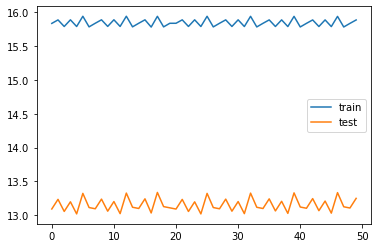

In [96]:
from matplotlib import pyplot
pyplot.plot(quadhistory.history['loss'], label='train')
pyplot.plot(quadhistory.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

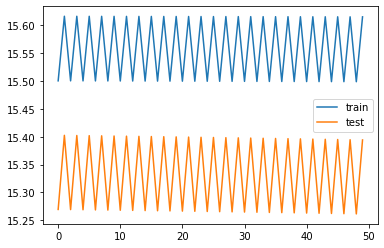

In [104]:
 # fit network
quadhistory = quadmodel.fit(xtrain_quad, ytrain_quad, epochs=50, batch_size=10, validation_data=(xtest_quad, ytest_quad), verbose=0, shuffle=False)

from matplotlib import pyplot
pyplot.plot(quadhistory.history['loss'], label='train')
pyplot.plot(quadhistory.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()